# 🏗️Import Necessary Libraries

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The code imports various data science libraries, including TensorFlow and scikit-learn, and defines a neural network model using the EfficientNet architecture. It also includes system libraries for handling file paths and metrics for evaluating model performance. Additionally, it sets up various callbacks and optimizers to optimize the training process.</p>

In [28]:
#!pip install tensorflow
#!pip install opencv-python
#!pip install cv2
# !pip install BIRDS
# pip install --upgrade --user pip
# !pip install google.colab

In [29]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path

# import birds_utils.BIRDS
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns
import birds_utils as birds
sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# !pip install itables
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

In [30]:
# principle parameters
BATCH_SIZE = 32 # size of batch (The ImageDataGenerator objects generate batches of tensor image data with real-time data augmentation)
TARGET_SIZE = (224, 224)    # size of pictures (used by the ImageDataGenerator objects)
N_LABELS = 2 # 'all'    # number of lables for analysis ('all will keep all labels)
N_EPOCHS = 5 # number of epochs for the traning NN
N_SAMPLES_PER_LABEL = 'all' #100 # number of sampels per label that are kept for training ('all' will keep all samples)

# 🤙Create helper functions

In [31]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# # Import series of helper functions for our notebook
# from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [32]:
# import urllib.request

# url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
# filename = "helper_functions.py"
# urllib.request.urlretrieve(url, filename)

# 📥Load and Transform Data

In [33]:
project_dir = '.'
image_df_full = birds.load_data(project_dir)  

In [34]:
def filter_df(df,labels=None,N_samples_per_label=None):
  if isinstance(labels, str):
    labels = [labels]

  df_filt = pd.DataFrame()
  if (labels != None):        
    df_filt = df[df['label'].isin(labels)]

  elif (N_samples_per_label !=None):
    labels = birds.get_labels(df)
    for label in labels:
      df_tmp = filter_df(df,labels=list([label]))
      # print(df_filt)
      df_tmp = df_tmp.iloc[0:min(N_samples_per_label,df_tmp.shape[0])]
      df_filt = pd.concat([df_filt,df_tmp])
    
  return df_filt


In [35]:
def filter_df(df,labels=None,N_samples_per_label=None):
  if isinstance(labels, str):
    labels = [labels]

  df_filt = pd.DataFrame()
  if (labels != None): 
    print(labels)
    if (labels=='all'):
      df_filt = df
    else:  
      df_filt = df[df['label'].isin(labels)]

  elif (N_samples_per_label !=None):
    if (N_samples_per_label=='all'):
      df_filt = df
    else:
      labels = get_labels(df)
      for label in labels:
        df_tmp = filter_df(df,labels=list([label]))
        df_tmp = df_tmp.iloc[0:min(N_samples_per_label,df_tmp.shape[0])]
        df_filt = pd.concat([df_filt,df_tmp])
    


  return df_filt

In [36]:
if (N_LABELS=='all'):
    N_LABELS = len(birds.get_labels(image_df_full))
    
lables = list(birds.get_labels(image_df_full)[0:N_LABELS])
image_df = birds.filter_df(image_df_full,labels=lables)
# image_df = birds.filter_df(image_df,N_samples_per_label=10)


In [37]:
image_df

Filepath            label
0    data\train\ABBOTTS BABBLER\001.jpg  ABBOTTS BABBLER
1    data\train\ABBOTTS BABBLER\002.jpg  ABBOTTS BABBLER
2    data\train\ABBOTTS BABBLER\003.jpg  ABBOTTS BABBLER
3    data\train\ABBOTTS BABBLER\004.jpg  ABBOTTS BABBLER
4    data\train\ABBOTTS BABBLER\005.jpg  ABBOTTS BABBLER
..                                  ...              ...
681    data\train\ABBOTTS BOOBY\176.jpg    ABBOTTS BOOBY
682    data\train\ABBOTTS BOOBY\177.jpg    ABBOTTS BOOBY
683    data\train\ABBOTTS BOOBY\178.jpg    ABBOTTS BOOBY
684    data\train\ABBOTTS BOOBY\179.jpg    ABBOTTS BOOBY
685    data\train\ABBOTTS BOOBY\180.jpg    ABBOTTS BOOBY

[686 rows x 2 columns]

# 🔭Visualizing images from the dataset

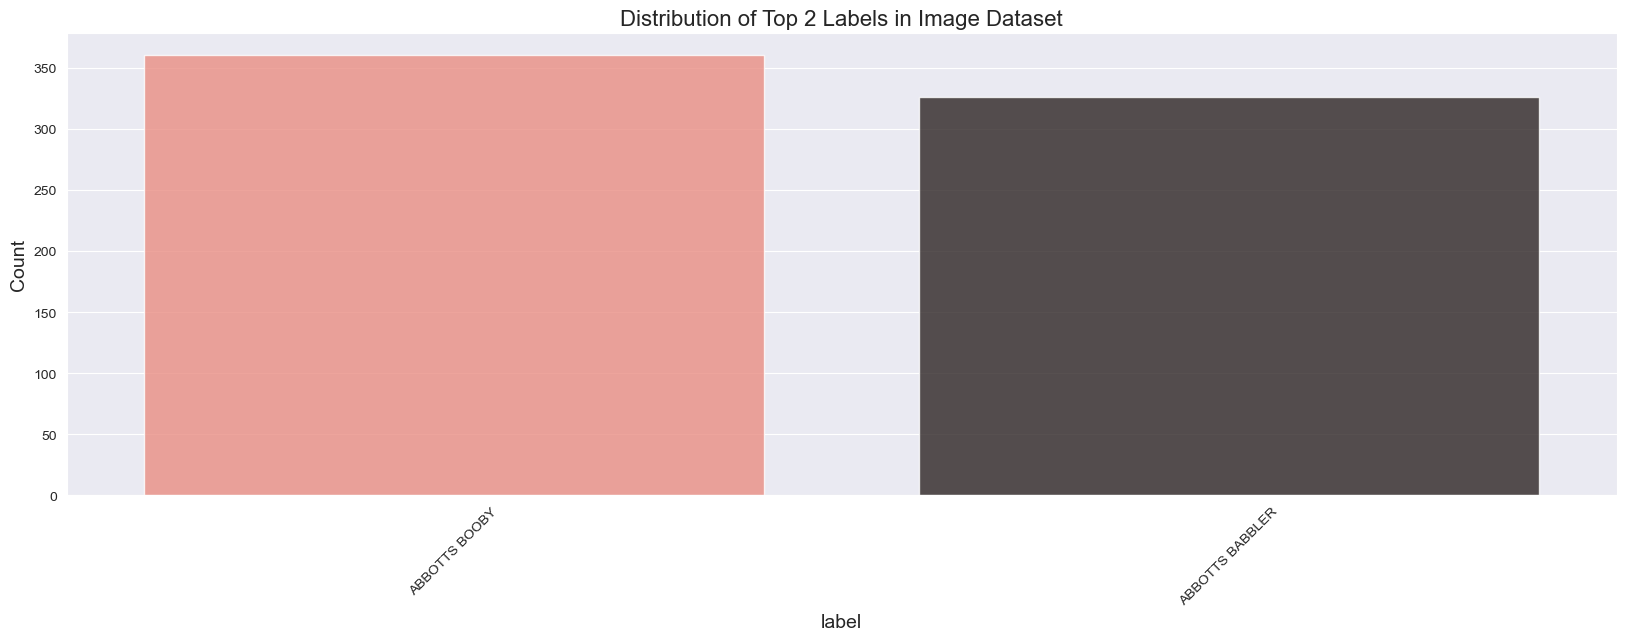

In [38]:
# birds.image_df
# plot all images of a label
# birds.plot_label_images(image_df,label=birds.get_labels(image_df)[1])
# plot the 1'st 5 instances of a label
# birds.plot_label_images(image_df,label=birds.get_labels(image_df)[1],N=5)

# # plot images according to idx
# birds.plot_label_images(image_df,idx=[1,9])

birds.plot_labels_count(image_df)

# 📝Data Preprocessing
<div style="background-color:#fff1cc; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).</p>
</div>

In [39]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [40]:
train_df

Filepath            label
278    data\train\ABBOTTS BOOBY\116.jpg    ABBOTTS BOOBY
110  data\train\ABBOTTS BABBLER\111.jpg  ABBOTTS BABBLER
82   data\train\ABBOTTS BABBLER\083.jpg  ABBOTTS BABBLER
51   data\train\ABBOTTS BABBLER\052.jpg  ABBOTTS BABBLER
218    data\train\ABBOTTS BOOBY\056.jpg    ABBOTTS BOOBY
..                                  ...              ...
71   data\train\ABBOTTS BABBLER\072.jpg  ABBOTTS BABBLER
106  data\train\ABBOTTS BABBLER\107.jpg  ABBOTTS BABBLER
270    data\train\ABBOTTS BOOBY\108.jpg    ABBOTTS BOOBY
435  data\train\ABBOTTS BABBLER\093.jpg  ABBOTTS BABBLER
102  data\train\ABBOTTS BABBLER\103.jpg  ABBOTTS BABBLER

[548 rows x 2 columns]

In [41]:
test_df

Filepath            label
286    data\train\ABBOTTS BOOBY\124.jpg    ABBOTTS BOOBY
652    data\train\ABBOTTS BOOBY\147.jpg    ABBOTTS BOOBY
257    data\train\ABBOTTS BOOBY\095.jpg    ABBOTTS BOOBY
336    data\train\ABBOTTS BOOBY\174.jpg    ABBOTTS BOOBY
318    data\train\ABBOTTS BOOBY\156.jpg    ABBOTTS BOOBY
..                                  ...              ...
333    data\train\ABBOTTS BOOBY\171.jpg    ABBOTTS BOOBY
506    data\train\ABBOTTS BOOBY\001.jpg    ABBOTTS BOOBY
24   data\train\ABBOTTS BABBLER\025.jpg  ABBOTTS BABBLER
158  data\train\ABBOTTS BABBLER\159.jpg  ABBOTTS BABBLER
517    data\train\ABBOTTS BOOBY\012.jpg    ABBOTTS BOOBY

[138 rows x 2 columns]

In [42]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [43]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 439 validated image filenames belonging to 2 classes.
Found 109 validated image filenames belonging to 2 classes.
Found 138 validated image filenames belonging to 2 classes.


In [44]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

# 🤹Training the model
<div style="background-color:#fff1cc; padding: 20px;">
  <p style="font-size:20px; font-family:verdana; line-height: 1.7em">The model images will be subjected to a pre-trained CNN model called EfficientNetB0. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:</p>

  <p style="font-size:20px">
    <strong>Batch size</strong>: 32<br>
    <strong>Epochs</strong>: 100<br>
    <strong>Input Shape</strong>: (224, 224, 3)<br>
    <strong>Output layer</strong>: 525
  </p>
</div>




In [45]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [46]:
# Create checkpoint callback
checkpoint_path = "birds_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# 🚄Training the model

In [47]:
inputs = pretrained_model.input
inputs.__dict__['_type_spec']

TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_2')

In [48]:
inputs = pretrained_model.input
x = augment(inputs)
x = Dense(128, activation='relu')(pretrained_model.output) #pretrained_model(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(N_LABELS, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [49]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 224, 224, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 224, 224, 3)          7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 224, 224, 3)          0         ['normalization_1[0][0]'

In [50]:
N_EPOCHS

5

In [51]:
import helper_functions
from helper_functions import create_tensorboard_callback

In [52]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=N_EPOCHS,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "bird_classification"),
        checkpoint_callback,
        reduce_lr
    ]
)

entered to create_tensorboard_callback
Saving TensorBoard log files to: training_logs/bird_classification/20240107-225936
Epoch 1/5


14/14 [==============================] - 30s 1s/step - loss: 1.3201 - accuracy: 0.6355 - val_loss: 0.2051 - val_accuracy: 0.9358 - lr: 1.0000e-04
Epoch 2/5
14/14 [==============================] - 15s 1s/step - loss: 0.7024 - accuracy: 0.7654 - val_loss: 0.1034 - val_accuracy: 0.9725 - lr: 1.0000e-04
Epoch 3/5
14/14 [==============================] - 14s 1s/step - loss: 0.3100 - accuracy: 0.8907 - val_loss: 0.0664 - val_accuracy: 0.9817 - lr: 1.0000e-04
Epoch 4/5
14/14 [==============================] - 15s 1s/step - loss: 0.1600 - accuracy: 0.9180 - val_loss: 0.0564 - val_accuracy: 0.9817 - lr: 1.0000e-04
Epoch 5/5
14/14 [==============================] - 14s 1s/step - loss: 0.1339 - accuracy: 0.9317 - val_loss: 0.0549 - val_accuracy: 0.9817 - lr: 1.0000e-04


# ✔️Model Evaluation
<div style="background-color:#f2f2f2; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:   </p>

<h3>Precision(P):</h3>
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.</p>

<h4>
  <center>
    <span style="font-size: 1.5em">
      $P = \frac{TP}{TP+FP}$
    </span>
  </center>
</h4>


<h3>Recall(R): </h3>
<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.</p>

<h4>
  <center>
    <span style="font-size: 1.5em">
      $R = \frac{TP}{TP+FN}$
    </span>
  </center>
</h4>


<h3>F1 score(F1): </h3>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.</p>

<h4>
  <center>
    <span style="font-size: 1.5em">
      $F1 = 2 \times \frac{TP \times FP}{TP + FP}$
    </span>
  </center>
</h4>
</div>

In [53]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.04636
Test Accuracy: 98.55%


# 📉Visualizing loss curves

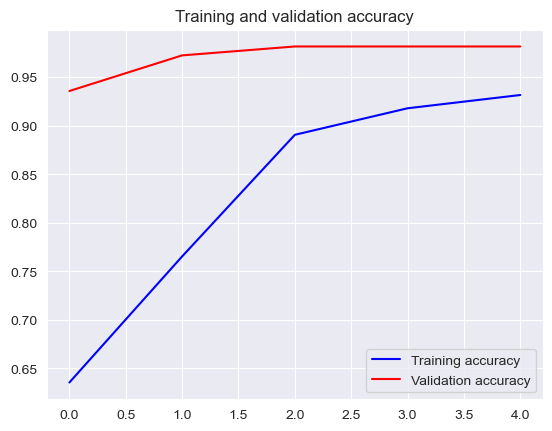

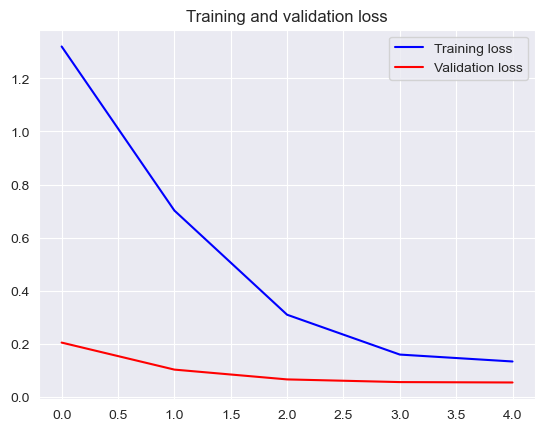

In [54]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

# 🔮Making predictions on the Test Data

In [46]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

1/1 [==============================] - 1s 1s/step
The first 5 predictions: ['ABYSSINIAN GROUND HORNBILL', 'ABYSSINIAN GROUND HORNBILL', 'ABYSSINIAN GROUND HORNBILL', 'ABYSSINIAN GROUND HORNBILL', 'ABYSSINIAN GROUND HORNBILL']


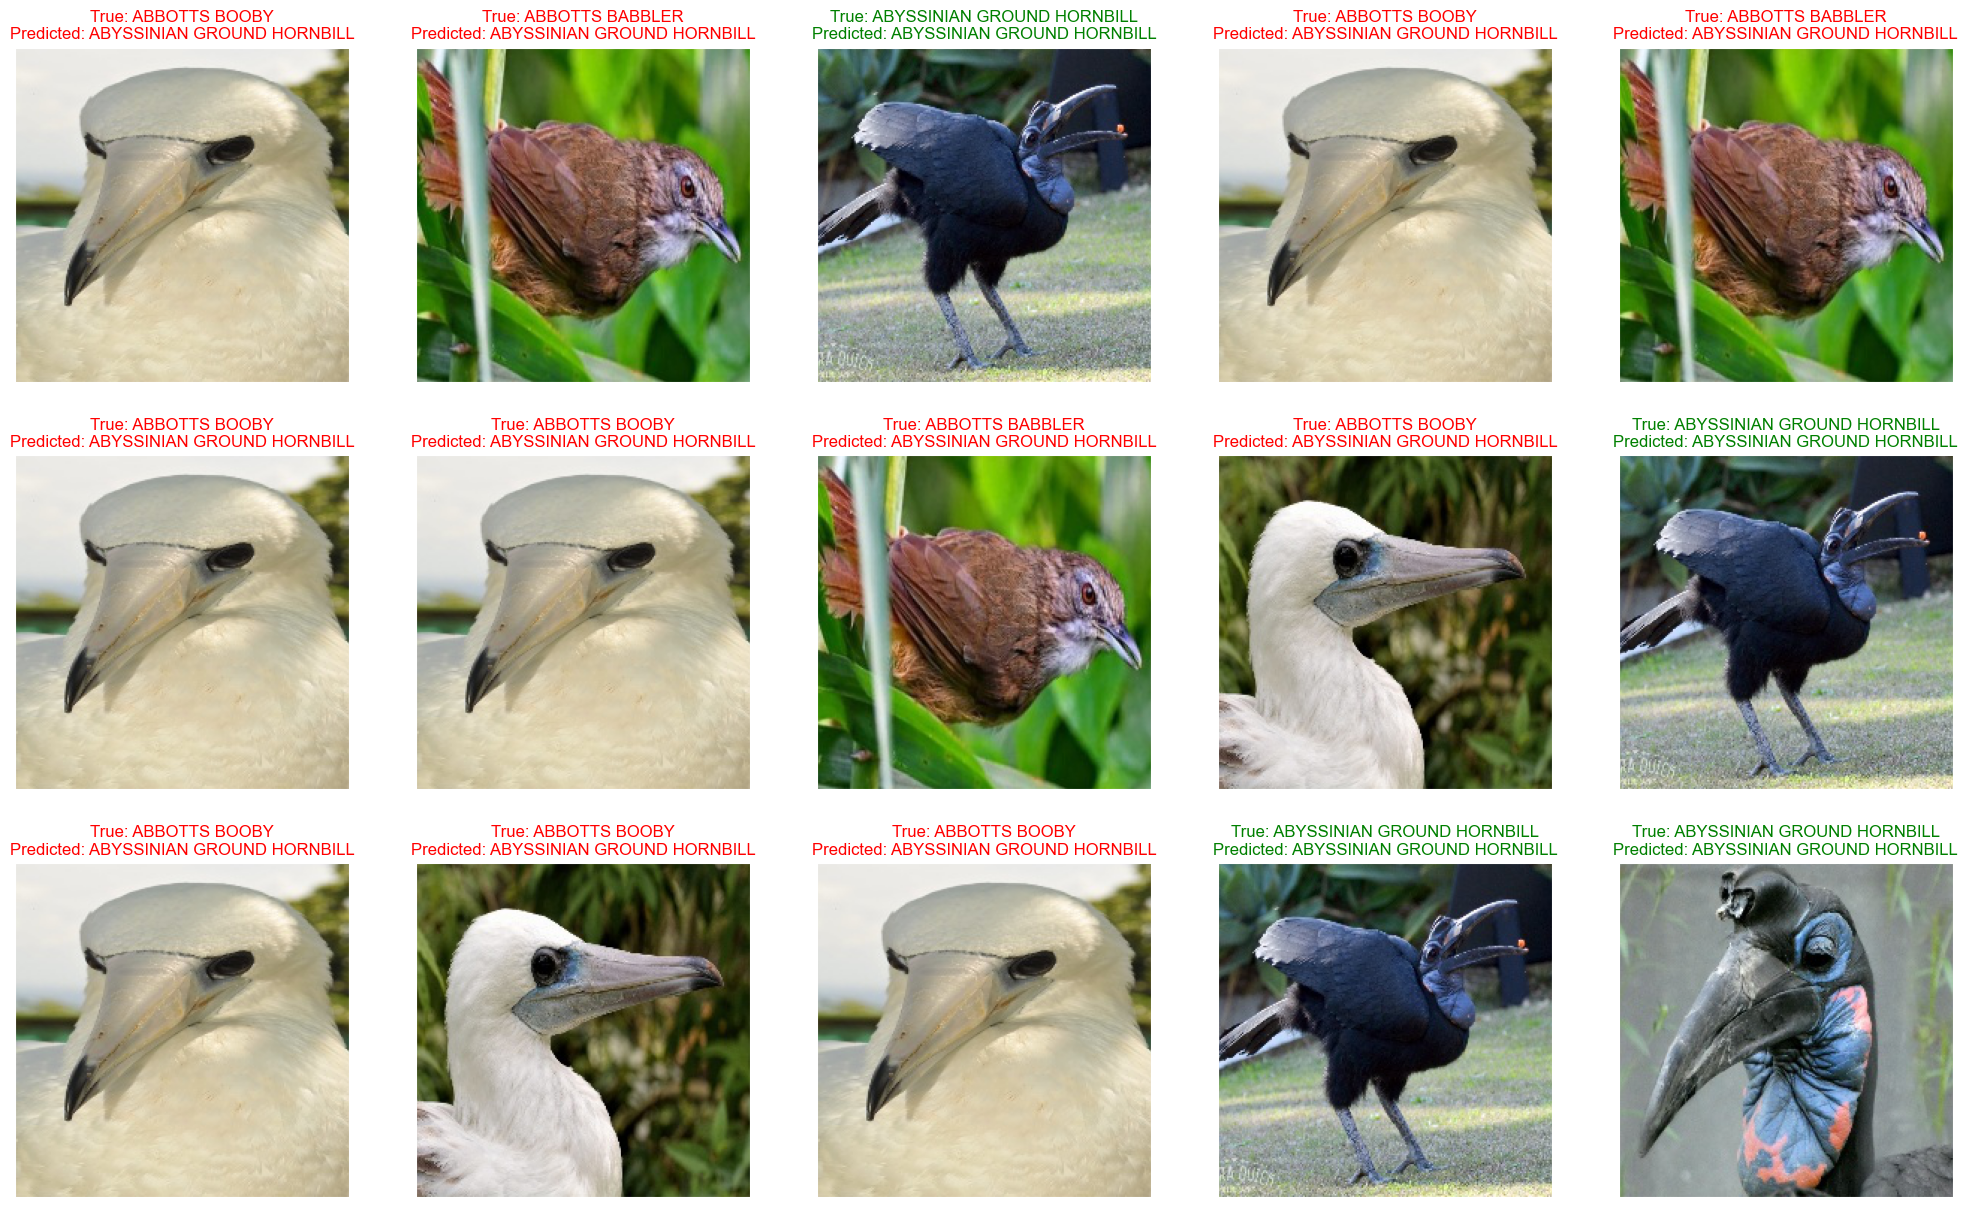

<Figure size 640x480 with 0 Axes>

In [47]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# 📊Plotting the Classification Reports and Confusion Matrix

<div style="background-color:#fff1cc; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em"><b>Confusion matrix</b> and <b>classification report</b> are two important tools used for evaluating the performance of an image classification model.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">A <b>confusion matrix</b> is a table that summarizes the number of correct and incorrect predictions made by a classification model on a set of test data. It is usually represented as a square matrix with rows and columns representing the predicted and true class labels, respectively. The entries of the matrix indicate the number of test samples that belong to a certain class, and how many of those were classified correctly or incorrectly by the model. A confusion matrix can provide a detailed breakdown of the performance of the model, including measures such as accuracy, precision, recall, and F1-score for each class. It can be used to identify specific areas where the model is making errors, and to diagnose problems with the model's predictions.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">A <b>classification report</b> is a summary of the key performance metrics for a classification model, including precision, recall, and F1-score, as well as the overall accuracy of the model. It provides a concise overview of the model's performance, typically broken down by class, and can be used to quickly assess the strengths and weaknesses of the model. The report is often presented as a table, with each row representing a class and columns showing various performance metrics. The report may also include other metrics such as support (the number of test samples belonging to a particular class), and the macro- and micro-averages of the performance metrics across all classes.</p>

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">In image classification, both confusion matrix and classification report are important tools for evaluating the performance of the model, identifying areas for improvement, and making decisions about how to adjust the model's architecture or training parameters.</p>
</div>

In [48]:
y_test = list(test_df.label)
print(classification_report(y_test, pred))

                            precision    recall  f1-score   support

           ABBOTTS BABBLER       0.00      0.00      0.00         2
             ABBOTTS BOOBY       0.00      0.00      0.00         2
ABYSSINIAN GROUND HORNBILL       0.33      1.00      0.50         2

                  accuracy                           0.33         6
                 macro avg       0.11      0.33      0.17         6
              weighted avg       0.11      0.33      0.17         6



c:\Users\gilad\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gilad\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gilad\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

c:\Users\gilad\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gilad\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gilad\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
ABBOTTS BABBLER,0.000000,0.000000,0.000000,2.000000
ABBOTTS BOOBY,0.000000,0.000000,0.000000,2.000000
ABYSSINIAN GROUND HORNBILL,0.333333,1.000000,0.500000,2.000000
accuracy,0.333333,0.333333,0.333333,0.333333
macro avg,0.111111,0.333333,0.166667,6.000000
weighted avg,0.111111,0.333333,0.166667,6.000000


# ☀️Grad-Cam Visualization

<div style="background-color:#fff1cc; padding: 20px;">
<p style="font-size:20px; font-family:verdana; line-height: 1.7em"><b>Grad-CAM (Gradient-weighted Class Activation Mapping)</b> is a technique used to visualize the regions of an input image that were most relevant for a neural network's prediction. It allows you to see which regions of the image the model focused on while making its prediction. Grad-CAM is a modification of the CAM technique that extends the latter to any model that uses a convolutional neural network (CNN) as its underlying architecture.</p>
</div>

In [50]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))

    return cam_path


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "top_conv"
img_size = (224,224, 3)

# Remove last layer's softmax
model.layers[-1].activation = None

ValueError: No such layer: top_conv. Existing layers are: ['input_2', 'sequential_1', 'efficientnetb0', 'dense_3', 'dropout_2', 'dense_4', 'dropout_3', 'dense_5'].

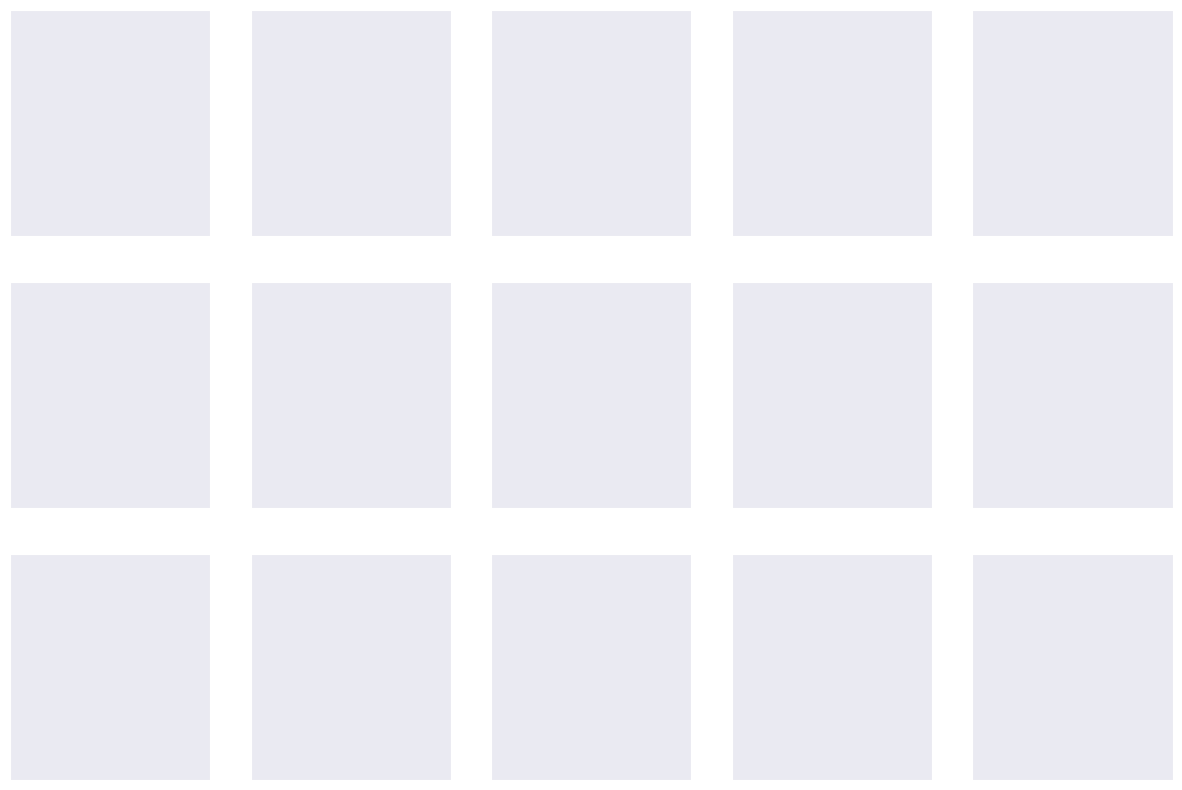

In [51]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[random_index[i]]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}")
plt.tight_layout()
plt.show()

***

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
        <p style="padding: 10px;
              color:white;">
            Thanks for viewing my work. If you like it, consider sharing it to others or give feedback to improve the notebook. Have a beautiful day my friend.
        </p>
    </div>

<center><img src='https://media4.giphy.com/media/M9gbBd9nbDrOTu1Mqx/giphy.gif?cid=790b7611704aa2ca4e403287801480a6c753abf45f3e6242&rid=giphy.gif&ct=s'
     height=30px width=160px /></center>